# Sistema de recomendación

In [36]:
import pandas as pd

In [40]:
df = pd.read_csv("data.csv")

In [41]:
type(df)

pandas.core.frame.DataFrame

In [42]:
df.head()

UserID  ItemID  puntajes        date
0       1       5         1  11/30/2020
1       2      13        11  11/30/2020
2       3      15         1  11/30/2020
3       4       6         2  11/30/2020
4       5      10         4  11/30/2020

### Análisis exploratorio de lo ítems

In [43]:
import matplotlib.pyplot as plt

(array([209., 180., 151.,  50.,  17.,  21.,  23.,  13.,  10.,   2.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <BarContainer object of 10 artists>)

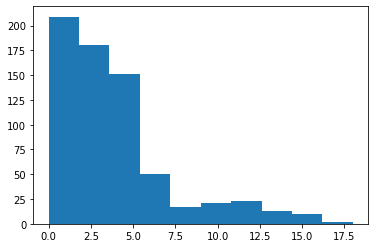

In [44]:
plt.hist(df.puntajes)

(array([102.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 574.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

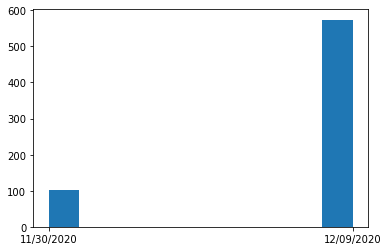

In [45]:
plt.hist(df.date)

In [217]:
df.groupby(["puntajes"])["UserID"].count()

puntajes
0     130
1      79
2     106
3      74
4     100
5      51
6      27
7      23
8      17
9       7
10     14
11     13
12     10
13      6
14      7
15      6
16      4
18      2
Name: UserID, dtype: int64

In [47]:
df.groupby(["ItemID"])["UserID"].count()

ItemID
1     33
2     49
3     40
4     40
5     39
6     39
7     41
8     38
9     43
10    39
11    45
12    37
13    46
14    40
15    40
16    37
17    30
Name: UserID, dtype: int64

(array([1., 1., 0., 2., 4., 5., 1., 1., 1., 1.]),
 array([30. , 31.9, 33.8, 35.7, 37.6, 39.5, 41.4, 43.3, 45.2, 47.1, 49. ]),
 <BarContainer object of 10 artists>)

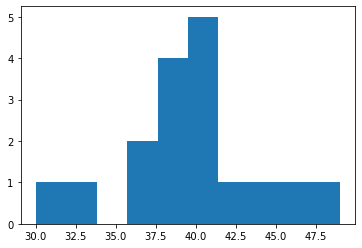

In [48]:
plt.hist(df.groupby(["ItemID"])["ItemID"].count()) 

### Representación en forma matricial

In [49]:
import numpy as np

#### Total personas que realizaron test vocacional

In [51]:
n_users = df.UserID.unique().shape[0]
n_users

676

#### Total carreras profesionales

In [52]:
n_items = df.ItemID.unique().shape[0]
n_items

17

In [53]:
puntajes = np.zeros((n_users,n_items))

In [54]:
for row in df.itertuples():
    puntajes[row[1] -1, row[2]-1] = row[3]

In [55]:
type(puntajes)

numpy.ndarray

In [56]:
puntajes.shape

(676, 17)

In [57]:
puntajes

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
sparsity = float(len(puntajes.nonzero()[0]))
sparsity /= (puntajes.shape[0]*puntajes.shape[1])
sparsity *= 100
print("Coeficiente de sparcidad: {:4.2f}%".format(sparsity))

Coeficiente de sparcidad: 4.75%


### Crear conjuntos de entranamiento y validación

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
puntajes_train, puntajes_test = train_test_split(puntajes, test_size = 0.3, random_state=42)

In [64]:
puntajes_train.shape

(473, 17)

In [65]:
puntajes_test.shape

(203, 17)

### Filtro colaborativo basado en Usuarios
* Matriz de similaridad entre los usuarios (distancia del coseno)
* Predecir la valaración desconocido de un item *i* para un usuario activo *u* basandonos en la suma poderada de todas las valoraciones del resto de usuarios para dicho carrera.
* Recomendaremos los nuevas carreras a los usuarios según lo establecido en los pasos anteriores

In [66]:
import numpy as np
import sklearn

In [67]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(puntajes_train)

In [68]:
type(sim_matrix)

numpy.ndarray

In [69]:
sim_matrix.shape

(473, 473)

In [70]:
sim_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [73]:
users_predictions = sim_matrix.dot(puntajes_train) / np.array([np.abs(sim_matrix).sum(axis=1)]).T

In [74]:
users_predictions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
from sklearn.metrics import mean_squared_error

In [76]:
def get_mse(preds, actuals):
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds,actuals)

In [77]:
get_mse(users_predictions, puntajes_train)

8.277047947638671

In [78]:
get_mse(users_predictions, puntajes_test)

32.391946226039344

### Filtro colaborativo basado en Carreras

In [187]:
n_carreras = puntajes_train.shape[1]
n_carreras

17

In [188]:
neighbors = NearestNeighbors(n_carreras, 'cosine')

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=17, radius=cosine as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [189]:
neighbors.fit(puntajes_train.T)

NearestNeighbors(n_neighbors=17, radius='cosine')

In [192]:
top_k_distances, top_k_items = neighbors.kneighbors(puntajes_train.T, return_distance=True)

In [193]:
top_k_distances.shape

(17, 17)

In [195]:
top_k_items.shape

(17, 17)

In [201]:
top_k_items

array([[ 0, 16, 11,  7,  2, 15,  9, 13, 14,  5,  4,  6,  8, 10, 12,  3,
         1],
       [ 1, 16, 11,  7,  2, 15,  9, 13, 14,  5,  4,  0,  6,  8, 10, 12,
         3],
       [ 2, 16, 11,  7, 15,  9, 13, 14,  5,  4,  0,  6,  8, 10, 12,  3,
         1],
       [ 3, 16, 11,  7,  2, 15,  9, 13, 14,  5,  4,  0,  6,  8, 10, 12,
         1],
       [ 4, 16, 11,  7,  2, 15,  9, 13, 14,  5,  0,  6,  8, 10, 12,  3,
         1],
       [ 5, 16, 11,  7,  2, 15,  9, 13, 14,  4,  0,  6,  8, 10, 12,  3,
         1],
       [ 6, 16, 11,  7,  2, 15,  9, 13, 14,  5,  4,  0,  8, 10, 12,  3,
         1],
       [ 7, 16, 11,  2, 15,  9, 13, 14,  5,  4,  0,  6,  8, 10, 12,  3,
         1],
       [ 8, 16, 11,  7,  2, 15,  9, 13, 14,  5,  4,  0,  6, 10, 12,  3,
         1],
       [ 9, 16, 11,  7,  2, 15, 13, 14,  5,  4,  0,  6,  8, 10, 12,  3,
         1],
       [10, 16, 11,  7,  2, 15,  9, 13, 14,  5,  4,  0,  6,  8, 12,  3,
         1],
       [11, 16,  7,  2, 15,  9, 13, 14,  5,  4,  0,  6,  8, 10, 1

In [196]:
item_preds = puntajes_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [197]:
item_preds.shape

(473, 17)

In [198]:
item_preds

array([[0.        , 0.02065285, 0.05864224, ..., 0.17949944, 0.19795342,
        0.27377142],
       [0.        , 0.06146747, 0.13925179, ..., 0.28807264, 0.31639949,
        0.42937707],
       [0.        , 0.09214336, 0.20106762, ..., 0.22229784, 0.27083071,
        0.34632543],
       ...,
       [0.        , 0.13821504, 0.30160142, ..., 0.33344676, 0.40624607,
        0.51948815],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [199]:
get_mse(item_preds, puntajes_train)

28.304617165828784

In [200]:
get_mse(item_preds, puntajes_test)

31.62050461949204